# Introduction

This notebook deals with visualizing relationships between Youtube channels. On the platform, creators are able to feature other Youtube channels on their channels page. Most of them use it to recommend similar content to their users, to promote friends or other channels that belong to the same institution the recommending channel belongs to. 

These featured channels make it possible to investigate relationships between channels. It allows us to find clusters of channels, i.e., channels that recommend each other frequently. This might for example be applied to find Youtube channels that promote conspiracy theories, since those likely won't link to mainstream media all too often and vice versa. Moreover, it might also be the case that clusters featuring different languages might emerge. In that case it would be possible to compare subscriber counts, channel types etc. among "cultures". 

### Imports

First of all, packages are imported. Numpy is used for array manipulation, pandas for handling dataframes, matplotlib for plotting, networkx to visualize graphs, re to use regular expressions, bs4 for convenient HTML parsing, and selenium to handle requests to Youtube. 

In [3]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import networkx as nx

import re

from bs4 import BeautifulSoup
from selenium.webdriver import Safari

### Youtube Channel Links

Youtube internally uses several types of unique identifiers. Historically, users had to define a user name that was their unique identifier. Nowadays, this username that was used as an identifier was replaced by a 24 character long unique identifer containing digits, characters and "-". 
Moreover, there is a third type of identifier Youtube uses. It is a username in combination with "c" as identifier type. 

Url templates for all types of identifiers and a generic one that can be used with all three of them can be found below

In [65]:
URL_CHANNEL_BY_ID = "https://www.youtube.com/channel/%s/channels"
URL_CHANNEL_BY_USERNAME = "https://www.youtube.com/user/%s/channels"
URL_CHANNEL_BY_NAME = "https://www.youtube.com/c/%s/channels"
URL_CHANNEL_BY_IDENTIFIER = "https://www.youtube.com%s/channels"

# URLS in the following format should be used:
# For channels with channel id: https://www.youtube.com/channel/UCUueEx_ceEQrjlR9ctPNKyg/channels
# For channels with user name: https://www.youtube.com/user/Nisi156/channels
# For channels with id looked up by name: https://www.youtube.com/c/FunkOfficial/channels

### Helper Functions

The functions defined below are used to parse subscriber counts that are displayed below most recommended channels and identifiers from internal hyperlinks within Youtube's website. The last function is used to assemble valid links to Youtube channels given an identifier and an identifier type.

In [66]:
# Regex to remove non-numerical characters from strings
NON_NUMERIC_REGEX = re.compile(r"[^0-9^,]")

# Splits internal hyperlinks into identifier and identifier type
def parse_identifier(identifier_string):
    identifier_string = identifier_string.split("/")

    # There are channels featured channels like /gaming that are not real channels
    if len(identifier_string) < 3: 
        return None, None

    identifier_type = identifier_string[1]
    identifier = identifier_string[2]
    return identifier, identifier_type

# Parses the subscriber count of featured channels
# NOTE: This should work in multiple languages, but was only tested on Youtube's German webpage
def parse_subs(subs_string): 
    subs_preliminary = re.sub(NON_NUMERIC_REGEX, "", subs_string).replace(",", ".")
    subs = int(subs_preliminary) if not "." in subs_preliminary else int(float(subs_preliminary) * 1e6)
    return subs

# Returns full link to a channel given its identifier and identifier type
def identifier_to_url(identifier, identifier_type): 
    match identifier_type: 
        case "channel":
            return URL_CHANNEL_BY_ID % (identifier)
        case "user": 
            return URL_CHANNEL_BY_USERNAME % (identifier)
        case "c": 
            return URL_CHANNEL_BY_NAME % (identifier)

### Parsing Featured Channels

For a given Youtube channel, the "channels" page is accessed and featured channels are extracted using the function scrape_channels. To make to request to Youtube's servers, a selenium webdriver is used that operates on top of Safari, since Youtube loads most of its website's contents dynamically and does not include them when making normal requests within python. They probably do this to promote their own API that gives them control over the API users' requests. 

Using selenium, however, the webpage can be loaded with all its contents and its HTML can be further processed using BeautifulSoup. 

In [67]:

# Returns a dict of featured channels given a channel's full identifier
# Dict's structure: 
# { full_identifier: (channel_name, subscriber_count, identifier, identifier_type),... }
def scrape_channels(full_identifier):

    request_url = URL_CHANNEL_BY_IDENTIFIER % (full_identifier)

    print("Scraping channels for", request_url)

    driver = Safari()
    driver.get(request_url)

    html = BeautifulSoup(driver.page_source)
    links = html.find_all('a', { 'id': 'channel-info' })

    channels = {}
    
    for link in links:

        texts = link.get_text().strip().split("\n")
        name = texts[0]
        full_identifier = link['href']
        identifier, identifier_type = parse_identifier(full_identifier)

        # There are special channels such as Youtube's gaming page that don't follow the usual pattern
        # Those channels are excluded from the investigation
        if identifier is None: 
            continue

        # If the subscriber count is hidden, it is set to -1
        subs = parse_subs(texts[1]) if len(texts) > 1 else -1
        channels.update({ full_identifier: (name, subs, identifier, identifier_type) })

    return channels

### Scraping Channels Recursively

Using the scrape_channels function, Youtube channels are scraped recursively. Thereby, the channels that are returned by scrape_channels are used as inputs for further function calls of the scrape_channels function. 

Already visited pages are thereby stored in a list, to increase performance and prevent scraping channels multiple times. During the whole process, a depth first search is employed. Hence, the tree of channels to scrape grows exponentially and reducing the branching factor of this tree by not visiting channels twice is an important measure to reduce the total number of requests to Youtube's servers. 

In [68]:
# Recursively traverses the featured channels and featured channels of second order of a given root channel
# Traversed channels are saved in the provided visited dict in the form: 
# { full_identifier: (channel_name, subscriber_count, identifier, identifier_type),... }
# Featured channels are saved in the dict links in the form: 
# { full_identifier: [full_identifier_child1, full_identifier_child2...], ... }
def scrape_bubble(full_identifier, depth, visited, links, leaves):

    # If the depth limit is reached, exploration is stopped
    if depth <= 0:
        leaves.append(full_identifier)
        return

    # Scrapes all featured channels for the current channel
    channels = scrape_channels(full_identifier)
    links.update({full_identifier : list(channels.keys())})

    for current_full_identifier, channel in channels.items():
        # Channels are only scraped if they weren't visited before
        if current_full_identifier not in visited:
            visited.update({current_full_identifier: channel})
            scrape_bubble(current_full_identifier, depth - 1, visited, links, leaves)

In [69]:
# Leaves have to be integrated into the full network, since otherwise,
# relationships they establish would not be counted
# However, only relationships with channels already in the graph are considered. 
# This means, that there is no further exploration
def include_leaves(leaves, visited, links): 
    for full_identifier in leaves: 
        channels = scrape_channels(full_identifier)
        links.update({full_identifier : [channel for channel in channels.keys() if channel in visited]})

### The Root Channel

The recursive process defined by scrape_bubble needs a start full identifier, a depth limit for the recursive search and the dicts visited and links to store the traversed channels in. 

As a root channel, I chose the German channel "funk". It is the official Youtube channel of the content creation network "funk" that is a cooperation between the German public broadcasters ZDF and ARD. "funk" specificially targets young adults aged 14 to 29. 

I chose "funk" as a root channel, since it should theoretically be more or less unbiased and should cover a multitude of topics reaching from documentaries and science conent to entertainment and comedy. 

Due to using selenium for requests and the fast growth of search tree, takes quite some time. Therefore, branching factors of more than 10 probably should not be tested, since the search will take a lot of time with such parameters. 

In [ ]:
full_start_identifier = "/c/FunkOfficial"
visited = {"/c/FunkOfficial": ("funk", 168000, "FunkOfficial", "c")}
links = {}
leaves = []

scrape_bubble(full_start_identifier, 6, visited, links, leaves)
include_leaves(leaves, visited, links)


### Mapping Identifiers to Channel Names and vice versa

The dicts visited and links use full_identifier as keys. links also uses them within the value-lists. For further processing and visualizations, it will be helpful, to be able to map full identifiers to channel names and vice versa. Thus, a set of all unique full identifiers is created in the following. This set is then used to create the following mappings: 

1. index_to_full_identifier
2. full_identifier_to_index
3. index_to_name

In [71]:
keys = set(links.keys())
values = set([link for channel_links in links.values() for link in channel_links])

# All full_identifiers for all scraped channels
# They will be used to create a full_identifier to channel name or int map
unique = keys.union(values)
nr_unique = len(unique)

index_to_full_identifier = list(unique)
full_identifier_to_index = dict(zip(index_to_full_identifier, range(nr_unique)))

index_to_name = [ visited[full_identifier][0] for full_identifier in unique ]

### Adjacency Matrix

Each channel is somehow connected to the other channels in our set. Connections are not weighted, i.e., there either is a connection or there is none. We can use an adjacency matrix to store the graph that is created by the relationships between channels. Given m channels, such a matrix has m columns and m rows, hence, m x m entries. Adjacency matrices are symmetric, if all relationships are symmetric. This would mean that a channel that is featured by another channel also features exactly this other channel.

During our search, however, it became apparent that there are some channels that don't feature other channels at all. Moreover, it of course is not a necessity that two channels feature each other. Lets suppose a small channel features a very well known channel, because that one is their favorite Youtuber. In that case, the favorite Youtuber who probably has several hundred thousand or even millions of subscribers probably does not feature the "fan" channel. 

Hence, it turns out that the created adjacency matrix is not symmetrical, which is possible, since we of course deal with directed graph. 

In [72]:
# Initializes an adjacency matrix of (size nr_unique x nr_unique) with zeros
adjacency_matrix = np.zeros(shape = (nr_unique, nr_unique))

# Iterates over the key and value pairs in links and sets entries of the adjacency matrix to 1 if there is a connection
for full_identifier, list_of_full_identifiers in links.items(): 
    index_i = full_identifier_to_index[full_identifier]

    for identifier in list_of_full_identifiers:
        index_j = full_identifier_to_index[identifier]
        
        adjacency_matrix[index_i, index_j] = 1

### Visualizing the Network

Given the adjacency matrix, the package "networkx" can be used to visualize the network of Youtube channels. Since we only know whether there are connections between channels or not we can only rely on relative positions of the channels to each other. In general, the positions of nodes - in our case channels - is arbitrary. Yet, to make the visualization visually appealing and to be able to see the relationships well, I chose a spring layout for the relative positions of the nodes. "networkx" describes the spring layout by the following: 

* *The algorithm simulates a force-directed representation of the network treating edges as springs holding nodes close, while treating nodes as repelling objects, sometimes called an anti-gravity force. Simulation continues until the positions are close to an equilibrium.*

Due to this procedure, nodes are as far apart from each other as possible and as close together as necessary to not fall apart completely. This results in a nice visualization.

#### Undirected Graph

In belows undirected graph, it is simply assumed that to channels are related, if at least one of the channels featured the other one. In this graph we cannot see whether both featured each other or the direction of the relationship. 

In [ ]:
graph = nx.Graph(adjacency_matrix)
position = nx.spring_layout(graph)
fig = plt.figure(1, figsize=(200, 200), dpi = 50)
nx.draw(graph, node_size = 400, font_size=30, pos = position, with_labels = True, labels = dict(zip(range(nr_unique), index_to_name)))

#### Directed Graph

In the following graph, directed edges are used. This makes it possible to see the direction of a relationship in the graph and therefore adds additional information to the visualization. 

In [ ]:
graph = nx.DiGraph(adjacency_matrix)
position = nx.spring_layout(graph)
fig = plt.figure(1, figsize=(200, 200), dpi = 50)
nx.draw(graph, node_size = 400, font_size=30, pos = position, with_labels = True, labels = dict(zip(range(nr_unique), index_to_name)))

### Investigating Meta Data

During our traversal of the search tree, we scraped the following information for each youtube channel: 

1. Name
2. Number of subscribers
3. Identifier
4. Channel type (c, channel, user)
5. Number of featured channels (For leaves: Only channels within the graph are counted, the actual count might be higher)
6. Featured channels

We can gather this information in a pandas dataframe. Given the dataframe, we can then investigate the distribution of subscriber counts, channel types and featured channels. 

In [7]:
data = pd.DataFrame(list(visited.values()), columns=["Name","Subs","Identifier","Type"])
data["Full_identifier"] = list(visited.keys())
data["Nr_featured"] = data["Full_identifier"].apply(lambda full_identifier: len(links[full_identifier]))
data["Featured"] = data["Full_identifier"].apply(lambda full_identifier: links[full_identifier])

print(data.shape)

data.head()

(711, 7)


,Name,Subs,Identifier,Type,Full_identifier,Nr_featured,Featured
0,funk,168000,FunkOfficial,c,/c/FunkOfficial,12,"[/channel/UC-2D0N8RCgWIHG6IbqCqmzQ, /channel/U..."
1,Ypsilon,19200,UC-2D0N8RCgWIHG6IbqCqmzQ,channel,/channel/UC-2D0N8RCgWIHG6IbqCqmzQ,7,"[/user/alwaysxcaro, /user/Dimxoo, /channel/UCl..."
2,alwaysxcaro,95200,alwaysxcaro,user,/user/alwaysxcaro,11,"[/channel/UC-0NMMeN8FRZTQJ4eLA6snQ, /channel/U..."
3,eve in lowercase,21300,UC-0NMMeN8FRZTQJ4eLA6snQ,channel,/channel/UC-0NMMeN8FRZTQJ4eLA6snQ,1,[/channel/UCM8qRGoiaLwmMv31L7xeeEQ]
4,Eve Cornwell,375000,UCM8qRGoiaLwmMv31L7xeeEQ,channel,/channel/UCM8qRGoiaLwmMv31L7xeeEQ,6,"[/channel/UC-0NMMeN8FRZTQJ4eLA6snQ, /channel/U..."


#### Distribution of Subscriber Counts

In the following distribution we notice, that most of the channels have less than 2.500.000 subscribers and that there are only a few channels with multiple millions subs. 

<AxesSubplot:ylabel='Frequency'>

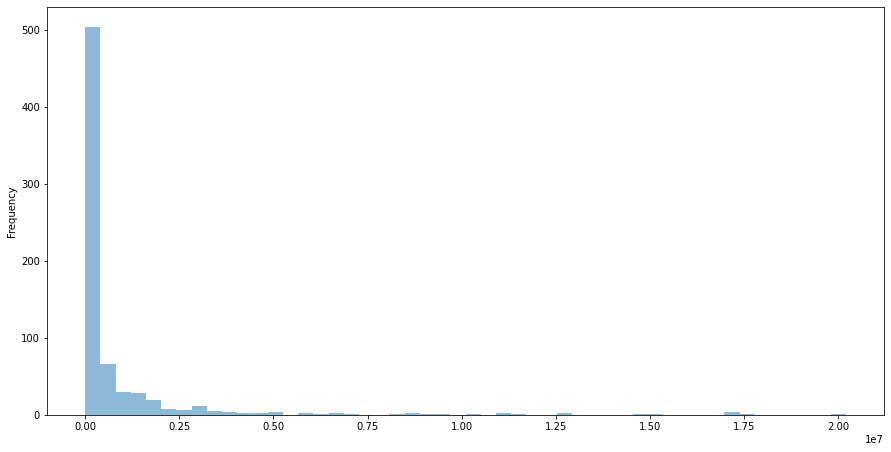

In [11]:
data["Subs"].plot.hist(bins = 50, alpha = 0.5, figsize=(15,7.5))

#### Distribution of Number of Feautred Channels

The number of featured channels is relevant, since it determines the growth of our search tree, per depth layer. The average branching factor is computed below. The distribution of the number of featured channels shows us that most channels actually feature only a small amount of channels or even no channels at all. 

In [77]:
# This average branching factor is not completely accurate, since again,
# "leave nodes" can have childs. They differ from inner nodes by the fact that 
# their childs can only be members of the graph and further exploration is prevented
average_branching_factor = data["Nr_featured"].mean()
average_branching_factor

2.70182841068917

<AxesSubplot:ylabel='Frequency'>

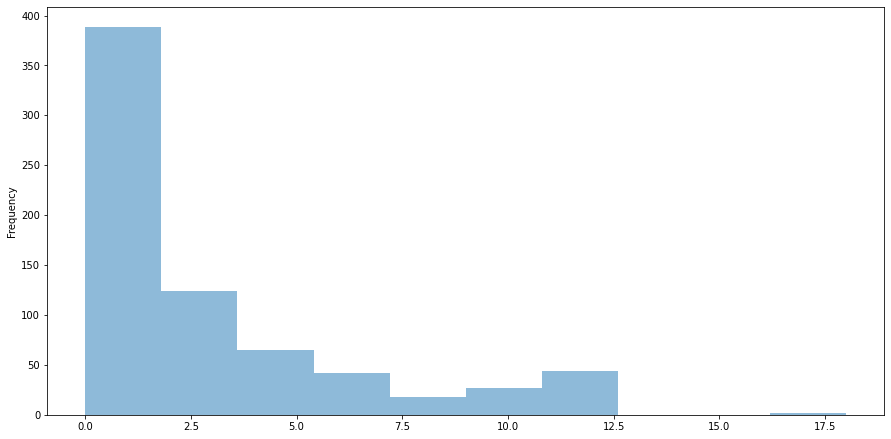

In [16]:
data["Nr_featured"].plot.hist(alpha = 0.5, figsize=(15,7.5))

#### Distribution of Channel Types

The distribution below shows that more than half of the scraped channels are actually Youtube "user" accounts. Those are legacy accounts that have been created before Youtube's switch to the new 24 character channel id. The single "c" is due to using an abbreviated link for "funk"'s channel as the root node. Those abbreviated channel links are not used by Youtube internally. Hence, "c" only occurs once. 

<AxesSubplot:>

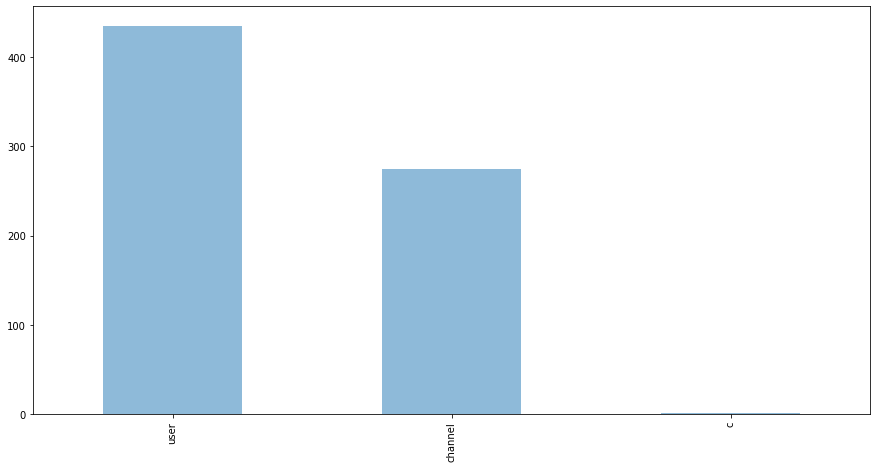

In [79]:
data['Type'].value_counts().plot.bar(alpha = 0.5, figsize=(15,7.5))

### Saving Data

As a last step, we save the dataframe to csv and the adjacency matrix and identifier index and index name mappings as numpy files. 

In [80]:
data.to_csv("channels")

In [81]:
backup = {
    "full_start_identifier": full_start_identifier,
    "visited": visited,
    "links": links,
    "adjacency_matrix": adjacency_matrix, 
    "index_to_full_identifier": index_to_full_identifier, 
    "full_identifier_to_index": full_identifier_to_index, 
    "index_to_name": index_to_name
}

np.save('backup.npy', backup)

### Loading Data

Saved data can be loaded into the notebook again. It can then be used as before, e.g., to create dataframes etc. 

In [6]:
backup = np.load("./Depth 6/backup.npy", allow_pickle='TRUE').item()

full_start_identifier = backup["full_start_identifier"]
visited = backup["visited"]
links = backup["links"]
adjacency_matrix = backup["adjacency_matrix"]
index_to_full_identifier = backup["index_to_full_identifier"]
full_identifier_to_index = backup["full_identifier_to_index"]
index_to_name = backup["index_to_name"]